<a href="https://colab.research.google.com/github/Mayur619/avc-detection/blob/notebooks/Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import os
import cv2
import pandas as pd
import numpy as np

from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras.layers import Conv2D,Activation,Input,Concatenate,Flatten,Dense
from tensorflow.keras.models import Model

In [2]:
from google.colab import drive
drive.mount('/content/drive')

KeyboardInterrupt: ignored

In [2]:
DATA_PATH = "/content/drive/My Drive/AnimalVehicleCollision/data"
EPOCHS = 100
BATCH_SIZE = 4
ANIMAL_LABELS_DICT = {0:"cow",1:"dog",2:"bear"}
WIDTH=512
HEIGHT=512

In [8]:
# Load training and validation dataframes
training_df = pd.read_csv(os.path.join(DATA_PATH,"train.csv"))
validation_df = pd.read_csv(os.path.join(DATA_PATH,"test.csv"))


In [66]:
class AnimalDataGenerator:
  def __init__(self,base_path,csv_path,batch_size):
    self.index=0
    self.base_path=base_path
    self.batch_size=batch_size
    self.df=pd.read_csv(csv_path)
  def __load_images(self,image_name_list,label_list):
    images=[]
    for i,image_name in enumerate(image_name_list):
      print(self.base_path,label_list[i],image_name)
      image=cv2.imread(os.path.join(self.base_path,ANIMAL_LABELS_DICT[label_list[i]],image_name))
      image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
      image=cv2.resize(image,(HEIGHT,WIDTH))
      images.append(image)
    return np.array(images)

  def generate_image_batches(self,is_training):
    while True:
      for i in range(self.df.shape[0]//self.batch_size):
        bounding_boxes=self.df.iloc[self.index:self.index+self.batch_size,2:6].values
        animal_labels=self.df.iloc[self.index:self.index+self.batch_size,6].values
        images=self.__load_images(self.df.iloc[self.index:self.index+self.batch_size,1].values,animal_labels)
        animal_labels=to_categorical(animal_labels,num_classes=len(ANIMAL_LABELS_DICT.keys()))
        orientation=to_categorical(self.df.iloc[self.index:self.index+self.batch_size,-1].values,num_classes=4)
        path=self.df.iloc[self.index:self.index+self.batch_size,7:9]
        print(bounding_boxes.shape,animal_labels.shape,images.shape,orientation.shape,path.shape)
        yield [bounding_boxes,animal_labels,images],[orientation,path]
        self.index+=self.batch_size
        del animal_labels,bounding_boxes,images,orientation,path
      self.index=0

In [67]:
train_gen=AnimalDataGenerator(os.path.join(DATA_PATH,"images"),"/content/drive/My Drive/AnimalVehicleCollision/data/train.csv",BATCH_SIZE)

In [68]:
x_train,y_train=next(train_gen.generate_image_batches(True))

/content/drive/My Drive/AnimalVehicleCollision/data/images 1 m_scene00641 (2).jpg
/content/drive/My Drive/AnimalVehicleCollision/data/images 1 m_im111ages.jpg
/content/drive/My Drive/AnimalVehicleCollision/data/images 0 scene00451.jpg
/content/drive/My Drive/AnimalVehicleCollision/data/images 0 m_scene01201.jpg
/content/drive/My Drive/AnimalVehicleCollision/data/images 0 images - 2020-11-02T123450.919.jpg
/content/drive/My Drive/AnimalVehicleCollision/data/images 0 m_cow_03541.jpg
/content/drive/My Drive/AnimalVehicleCollision/data/images 0 m_scene04861.jpg
/content/drive/My Drive/AnimalVehicleCollision/data/images 1 m_images38.jpg
/content/drive/My Drive/AnimalVehicleCollision/data/images 0 m_c___02221.jpg
/content/drive/My Drive/AnimalVehicleCollision/data/images 1 animals-auto-accidents.jpg
/content/drive/My Drive/AnimalVehicleCollision/data/images 0 c___00241.jpg
/content/drive/My Drive/AnimalVehicleCollision/data/images 1 m_scene02521.jpg
/content/drive/My Drive/AnimalVehicleColli

In [40]:
def cnn_model():
  input=Input(shape=(WIDTH,HEIGHT,3),name="image_input")
  model=Conv2D(16,(3,3),padding='same')(input)
  model=Activation('relu')(model)
  model=Flatten()(model)
  model=Dense(16)(model)
  return input,model

In [41]:
def bounding_box_model():
  input=Input(shape=(4),name="bounding_box_input")
  model=Dense(8)(input)
  model=Activation('relu')(model)
  model=Flatten()(model)
  return input,model

In [42]:
def animal_label_model():
  input=Input(shape=(len(ANIMAL_LABELS_DICT.keys())),name="animal_label_input")
  model=Dense(8)(input)
  model=Activation('relu')(model)
  model=Flatten()(model)
  return input,model

In [43]:
cnn_input,cnn_output=cnn_model()
bounding_box_input,bounding_box_output=bounding_box_model()
animal_label_input,animal_label_output=animal_label_model()
core_model=Concatenate(axis=1)([cnn_output,bounding_box_output,animal_label_output])
core_model=Dense(64)(core_model)
orientation=Dense(4,activation='softmax',name='orientation_output')(core_model)
path=Dense(2,name='path_output')(core_model)

In [44]:
model=Model(inputs=[cnn_input,bounding_box_input,animal_label_input],outputs=[orientation,path])

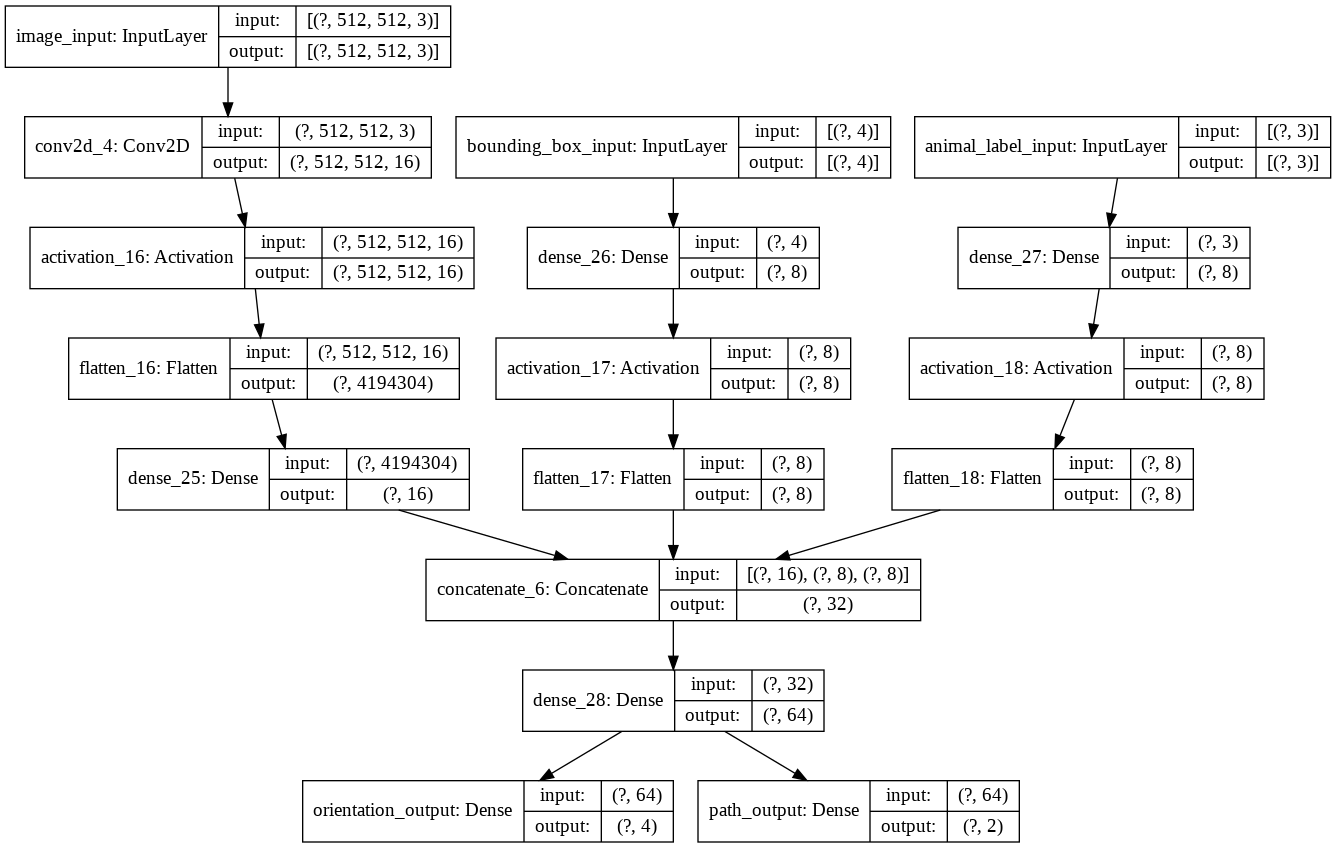

In [45]:
plot_model(model,to_file="model.png",show_shapes=True)

3